## Nevena's notebook

1. Missing values, which types
2. Systematic errors, how to make text cleaner
3. Cleaning steps:
- remove punctuation
- lowercase
- remove articles & pronouns
- deleting words with less than 3 letters
4. How many words should be kept? Find the perfect amount
5. Which columns to keep and which to throw out?

In [4]:
from google.cloud import storage
import os
from dotenv import load_dotenv
import pandas as pd
import io
from unidecode import unidecode
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import spacy
from langdetect import detect, LangDetectException
from io import BytesIO
import re

nlp = spacy.load("en_core_web_sm")

# Specify the bucket name
BUCKET_NAME = os.getenv("BUCKET_NAME")
GCP_PROJECT = os.getenv("GCP_PROJECT")

In [75]:
# Create a storage client
storage_client = storage.Client()

# Get the bucket
bucket = storage_client.get_bucket(BUCKET_NAME)

# Get the blob (file) from the bucket
file_name = 'david.csv'
blob = bucket.get_blob(file_name)

# Read the CSV file into a DataFrame
df_d = pd.read_csv(io.BytesIO(blob.download_as_bytes()), sep=",")

In [27]:
df_d.keys()

Index(['Title', 'Author', 'Label', 'Abstract', 'Main Body', 'Word Count',
       'Picture Count', 'Subject', 'Most Recurrent Word', 'Link',
       'is_english'],
      dtype='object')

In [76]:
#Dropping duplicates from the DF
df_d = df_d.drop_duplicates()
#Dropping the rows the rows in the 'Main Body' column that have NaN values
df_d = df_d.dropna(subset=['Main Body'])

In [32]:
#Creating a preprocessing function
def preprocess_text(text):
    """Preprocesses the given text by cleaning and lemmatizing it."""

    text = text.lower().strip()
    text = unidecode(text)
    text = ''.join(char for char in text if not char.isdigit())
    text = ''.join(char for char in text if char not in string.punctuation)

    #Additional code line, dropping the words less than 2 chars long
    text = ' '.join([word for word in text.split() if len(word) > 2])
    #end

    doc = nlp(text)
    filtered_tokens = [token.lemma_ for token in doc if not token.is_stop and len(token.lemma_) > 2
                       and token.pos_ not in ['PRON', 'DET']]
    return ' '.join(filtered_tokens)

def detect_english(text):
    """Detects if the given text is English."""
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False

def filter_english_text(df, text_column):
    """Filters the DataFrame to only include rows where the text is English."""
    df['is_english'] = df[text_column].apply(detect_english)
    filtered_df = df[df['is_english']].drop(columns=['is_english'])
    return filtered_df

In [15]:
def preprocessing_pipeline(df, text_column):
    """Applies text cleaning and English filtering to a DataFrame."""

    df = filter_english_text(df, text_column)

    if not df.empty:
        df['Processed Text'] = df[text_column].apply(preprocess_text)
    return df

In [16]:
def process_directory(directory_path, text_column):
    processed_dfs = []
    for filename in os.listdir(directory_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(directory_path, filename)
            df = pd.read_csv(file_path)
            processed_df = preprocessing_pipeline(df, text_column)
            processed_dfs.append(processed_df)

            processed_df.to_csv(f"../data/processed/processed_{filename}", index=False)
    return processed_dfs

## DavidWolfe Dataset

In [78]:
processed_df_d = preprocessing_pipeline(df_d, text_column='Main Body')

<Axes: xlabel='word_count', ylabel='Count'>

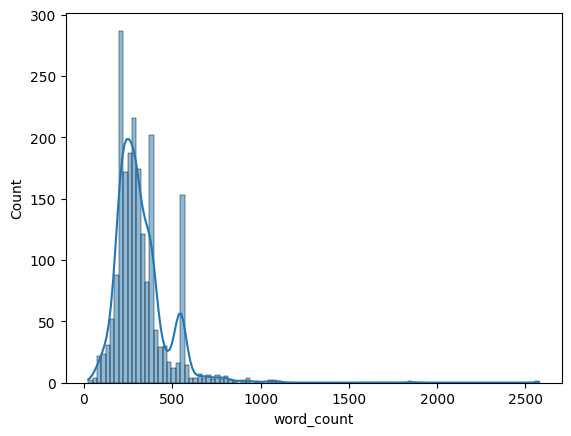

In [56]:
sns.histplot(processed_df_d['word_count'], kde=True)

In [100]:
processed_df_d.keys()

Index(['Title', 'Author', 'Published Date', 'Word Count', 'Most Frequent Word',
       'Link', 'Label', 'Primary Category', 'All Categories',
       'Processed Text'],
      dtype='object')

In [92]:
#Published Date, Primary Category, All Categories missing, adding empty columns
processed_df_d['Published Date'] = ""
processed_df_d['Primary Category'] = ""
processed_df_d['All Categories'] = ""

#Drop the rest of the columns
processed_df_d.drop(columns=['Abstract', 'Word Count',
                             'Picture Count', 'Subject', 'Main Body'], inplace=True)

processed_df_d['Word Count'] = processed_df_d['Processed Text'].apply(lambda n: len(n.split()))

KeyError: "['Abstract', 'Word Count', 'Picture Count', 'Subject'] not found in axis"

In [96]:
processed_df_d = processed_df_d.reindex(columns=['Title', 'Author', 'Published Date', 'Word Count',
       'Most Frequent Word', 'Link', 'Label',
       'Primary Category', 'All Categories', 'Processed Text'])

## Collective evolution dataset

In [113]:
# Get the blob (file) from the bucket
file_name = 'collective_evolution.csv'
blob = bucket.get_blob(file_name)

# Read the CSV file into a DataFrame
df_ce = pd.read_csv(io.BytesIO(blob.download_as_bytes()), sep=",")

In [114]:
#Dropping duplicates from the DF
df_ce = df_ce.drop_duplicates()
#Dropping the rows the rows in the 'Main Body' column that have NaN values
df_ce = df_ce.dropna(subset=['Main Body'])

In [111]:
df_ce.info()
df_ce.head(3)
df_ce.keys()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Title                21 non-null     object 
 1   Author               21 non-null     object 
 2   Label                21 non-null     int64  
 3   Abstract             21 non-null     object 
 4   Main Body            21 non-null     object 
 5   Word Count           21 non-null     int64  
 6   Picture Count        21 non-null     int64  
 7   Subject              0 non-null      float64
 8   Most Recurrent Word  21 non-null     object 
dtypes: float64(1), int64(3), object(5)
memory usage: 1.6+ KB


Index(['Title', 'Author', 'Label', 'Abstract', 'Main Body', 'Word Count',
       'Picture Count', 'Subject', 'Most Recurrent Word'],
      dtype='object')

In [115]:
processed_df_ce = preprocessing_pipeline(df_ce, text_column='Main Body')

In [120]:
processed_df_ce.keys()

Index(['Title', 'Author', 'Published Date', 'Word Count', 'Most Frequent Word',
       'Link', 'Label', 'Primary Category', 'All Categories',
       'Processed Text'],
      dtype='object')

In [117]:
# Most Reccurent Word rename
processed_df_ce.rename(columns={'Most Recurrent Word': 'Most Frequent Word'}, inplace=True)

# Published Date, Link, Primary Category, All Categories missing!
processed_df_ce['Published Date'] = ""
processed_df_ce['Primary Category'] = ""
processed_df_ce['All Categories'] = ""

In [119]:
processed_df_ce.drop(columns=['Abstract', 'Word Count',
                             'Picture Count', 'Subject', 'Main Body'], inplace=True)

processed_df_ce['Word Count'] = processed_df_ce['Processed Text'].apply(lambda n: len(n.split()))

processed_df_ce = processed_df_ce.reindex(columns=['Title', 'Author', 'Published Date', 'Word Count',
       'Most Frequent Word', 'Link', 'Label',
       'Primary Category', 'All Categories', 'Processed Text'])

## Arxiv Dataset

In [61]:
# Get the blob (file) from the bucket
file_name = 'arxiv.csv'
blob = bucket.get_blob(file_name)

# Read the CSV file into a DataFrame
df_a = pd.read_csv(io.BytesIO(blob.download_as_bytes()), sep=",")

In [62]:
#Dropping duplicates from the DF
df_a = df_a.drop_duplicates()
#Dropping the rows the rows in the 'Main Body' column that have NaN values
df_a = df_a.dropna(subset=['Main Body'])

In [63]:
df_a.info()
df_a.head(3)
df_a.keys()

<class 'pandas.core.frame.DataFrame'>
Index: 3422 entries, 0 to 3524
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   arxiv-id           3422 non-null   object
 1   Published          3422 non-null   object
 2   Title              3422 non-null   object
 3   Authors            3422 non-null   object
 4   Journal reference  3422 non-null   object
 5   Comments           3422 non-null   object
 6   Primary Category   3422 non-null   object
 7   All Categories     3422 non-null   object
 8   Abstract           3422 non-null   object
 9   Main Body          3422 non-null   object
 10  Word Count         3422 non-null   int64 
 11  PDF Link           3422 non-null   object
 12  Label              3422 non-null   int64 
dtypes: int64(2), object(11)
memory usage: 374.3+ KB


Index(['arxiv-id', 'Published', 'Title', 'Authors', 'Journal reference',
       'Comments', 'Primary Category', 'All Categories', 'Abstract',
       'Main Body', 'Word Count', 'PDF Link', 'Label'],
      dtype='object')

In [64]:
processed_df_a = preprocessing_pipeline(df_a, text_column='Main Body')

In [65]:
processed_df_a['word_count'] = processed_df_a['Processed Text'].apply(lambda n: len(n.split()))

<Axes: xlabel='word_count', ylabel='Count'>

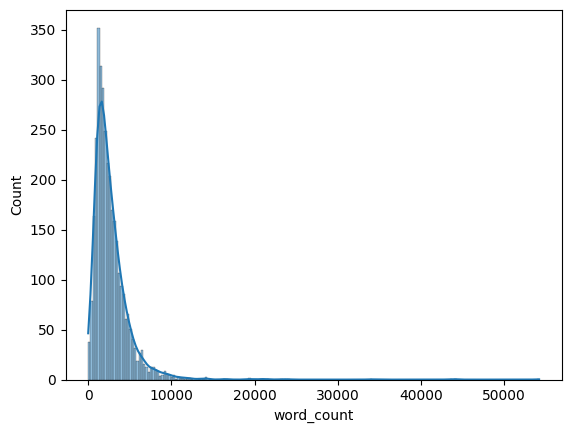

In [66]:
sns.histplot(processed_df_a['word_count'], kde=True)

In [72]:
# Authors Column rename and |
#Renaming Authors
processed_df_a['clean_authors'] = processed_df_a['Author'].str.replace("|", ", ")

# Publised, PDF Link rename
processed_df_a.rename(columns={'Published': 'Published Date'}, inplace=True)
processed_df_a.rename(columns={'PDF Link': 'Link'}, inplace=True)

# Most Freq Word missing, adding an empty column
processed_df_a['Most Frequent Word'] = ""

In [126]:
processed_df_a = processed_df_ce.reindex(columns=['Title', 'Author', 'Published Date', 'Word Count',
       'Most Frequent Word', 'Link', 'Label',
       'Primary Category', 'All Categories', 'Processed Text'])

In [127]:
processed_df_a.keys()

Index(['Title', 'Author', 'Published Date', 'Word Count', 'Most Frequent Word',
       'Link', 'Label', 'Primary Category', 'All Categories',
       'Processed Text'],
      dtype='object')

In [125]:
processed_df_a.drop(columns=['arxiv-id', 'Word Count', 'Journal reference',
                             'Comments', 'Abstract',
                             'Main Body', 'word_count', 'Author'], inplace=True)

processed_df_a['Word Count'] = processed_df_a['Processed Text'].apply(lambda n: len(n.split()))
processed_df_a.rename(columns={'clean_authors': 'Author'}, inplace=True)

KeyError: "['arxiv-id', 'Journal reference', 'Comments', 'Abstract', 'Main Body', 'word_count'] not found in axis"

Exporting to GCP

In [101]:
# Create a blob (file) object
file_name = 'david_cleaned.csv'
blob = bucket.blob(file_name)

# Convert the DataFrame to a CSV bytes object
csv_buffer = io.BytesIO()
processed_df_d.to_csv(csv_buffer, index=False)
csv_buffer.seek(0)

# Upload the CSV bytes object to GCS
blob.upload_from_file(csv_buffer)

In [121]:
# Create a blob (file) object
file_name = 'collective_evolution_cleaned.csv'
blob = bucket.blob(file_name)

# Convert the DataFrame to a CSV bytes object
csv_buffer = io.BytesIO()
processed_df_ce.to_csv(csv_buffer, index=False)
csv_buffer.seek(0)

# Upload the CSV bytes object to GCS
blob.upload_from_file(csv_buffer)

In [128]:
# Create a blob (file) object
file_name = 'arxiv_cleaned.csv'
blob = bucket.blob(file_name)

# Convert the DataFrame to a CSV bytes object
csv_buffer = io.BytesIO()
processed_df_d.to_csv(csv_buffer, index=False)
csv_buffer.seek(0)

# Upload the CSV bytes object to GCS
blob.upload_from_file(csv_buffer)